In [1]:
import numpy as np
import pandas as pd
from zipfile import ZipFile
import os
import rasterio
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from cartopy.feature import NaturalEarthFeature
import cartopy.crs as ccrs
import cartopy

In [2]:
lat = np.array([49.9166666666664 - i * 0.0416666666667 for i in range(357)])
lon = np.array([-105.0416666666507 + i * 0.0416666666667 for i in range(722)])
Lon, Lat = np.meshgrid(lon, lat)

am = rasterio.open('PRISM_tmin_stable_4kmD2_19810101_bil.bil')
a = am.read()[0, :357, 479:1201]
mask = np.where(a>-1000, 1, 0)
cherrymask = np.load('var/Cherry_mask.npy')

tmin81 = np.load('./prism/mw_tmin/1981_tmin.npz')['tmin']
t, y, x = tmin81.shape
y, x

(357, 722)

In [ ]:
# var_mean = [np.zeros((y, x)) * np.nan for i in range(5)]
# var_std = [np.zeros((y, x)) * np.nan for i in range(5)]
# slope = [np.zeros((y, x)) * np.nan for i in range(5)]
# pvalue = [np.zeros((y, x)) * np.nan for i in range(5)]
# X = np.linspace(1, 40, 40)
# name = ['year','sidegreen','bloom','pdays','yield']

# for i in range(y):
#     for j in range(x):
#         if mask[i, j]:
#             df = pd.read_table(f'./GDD/output_Cherry/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
#                                    names=('year','sidegreen','bloom','pdays','yield'))
#             for ii in range(1,5):
#                 var_mean[ii-1][i,j] = df[name[ii]].mean()
                
#                 var_detrend = df[name[ii]] - var_mean[ii-1][i, j]
#                 var_std[ii-1][i,j] = np.sqrt(((var_detrend - var_detrend.mean())**2).sum() / 40.)
                
#                 r = stats.linregress(X, df[name[ii]])
#                 slope[ii-1][i, j] = r.slope
#                 pvalue[ii-1][i, j] = r.pvalue
            
#             spring = df['bloom'] - df['sidegreen']
#             var_mean[-1][i,j] = spring.mean()
#             var_detrend = spring - var_mean[-1][i, j]
#             var_std[-1][i,j] = np.sqrt(((var_detrend - var_detrend.mean())**2).sum() / 40.)    
#             r = stats.linregress(X, spring)
#             slope[-1][i, j] = r.slope
#             pvalue[-1][i, j] = r.pvalue

# np.save('./GDD/var_yearly_Cherry', np.array(var_mean))
# np.save('./GDD/var_std_Cherry', np.array(var_std))
# np.save('./GDD/var_yearly__slope_Cherry', np.array(slope))
# np.save('./GDD/var_yearly_pvalue_Cherry', np.array(pvalue))

In [4]:
var_mean = np.load('./GDD/var_yearly_Cherry.npy')
var_std = np.load('./GDD/var_std_Cherry.npy')
var_slope = np.load('./GDD/var_yearly__slope_Cherry.npy')
var_pvalue = np.load('./GDD/var_yearly_pvalue_Cherry.npy')

In [5]:
data = []
pvalue = []
data.append(var_mean[0, :, :])
data.append(var_std[0, :, :])
data.append(var_slope[0, :, :])
pvalue.append(var_pvalue[0, :, :])
data.append(var_mean[1, :, :])
data.append(var_std[1, :, :])
data.append(var_slope[1, :, :])
pvalue.append(var_pvalue[1, :, :])
data.append(var_mean[4, :, :])
data.append(var_std[4, :, :])
data.append(var_slope[4, :, :])
pvalue.append(var_pvalue[4, :, :])

In [7]:
extent = [-105, -75, 34, 49]
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
ll = [60, 0, -.6, 0, 0, -.6, 0, 0, -.6]
lr = [160, 12, .6, 160, 12, .6, 30, 12, .6]
step = [20, 2, .2, 40, 2, .2, 6, 2, .2]
title = ['(a) side green mean', '(b) side green std', '(c) side green trend', '(d) full bloom mean', 
         '(e) full bloom std', '(f) full bloom trend', '(g) spring duration mean', '(h) spring duration std', 
         '(i) spring duration trend']
pc = []
for i in range(9):
    ax = plt.subplot(3,3,i+1, projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
    ax.set_extent(extent)
    ax.add_feature(cartopy.feature.BORDERS, lw=.1, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE, lw=.1, linestyle=':')
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)
    
    levels = MaxNLocator(nbins=100).tick_values(ll[i], lr[i])
    if i%3-2:
        cmap = plt.get_cmap('viridis')
    else:
        cmap = plt.get_cmap('bwr')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    pc.append(plt.pcolormesh(Lon, Lat, data[i], cmap=cmap, norm=norm, transform=ccrs.PlateCarree()))
    if i%3 == 2:
        plt.scatter(Lon, Lat, np.where(pvalue[int((i-2)/3)]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())
    ax.text(.01,1.03,title[i], fontsize=16, fontweight='bold',horizontalalignment='left',transform=ax.transAxes)
plt.subplots_adjust(bottom=0.02, top=.98, left=0.02, right=.98,
                    wspace=0.005, hspace=0.1)
i = 0
cb_ax = fig.add_axes([.005, 0.345, 0.01, 0.64])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
cb_ax.yaxis.set_ticks_position('left')
cb_ax.tick_params(labelsize=15) 
i = 2
cb_ax = fig.add_axes([0.985, .02, 0.01, 0.96])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='both')
cb_ax.tick_params(labelsize=15)
i = 6
cb_ax = fig.add_axes([0.005, .02, 0.01, 0.32])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
cb_ax.yaxis.set_ticks_position('left')
cb_ax.tick_params(labelsize=15)
i = 7
cb_ax = fig.add_axes([0.34, .005, 0.32, 0.01])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max', orientation="horizontal")
cb_ax.tick_params(labelsize=15)

plt.savefig('./plot/AgPaper/SpringDates.png', bbox_inches='tight')
plt.close()

<ipython-input-7-732d1969cbcf>:27: RuntimeWarning: invalid value encountered in less
  plt.scatter(Lon, Lat, np.where(pvalue[int((i-2)/3)]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())


In [11]:
np.nanmax(var_std[1])

10.842941252261769

In [ ]:
np.nanmax(data[7])

### Region definition

In [92]:
from matplotlib.colors import LinearSegmentedColormap
states = ['MI', 'ND', 'SD', 'NE', 'KS', 'OK', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'OH', 'KY', 'WV', 'PA', 'AR', 'TN', 'NY', 'MD', 'VA', 'NC']
mdmask = {states[ii]:np.load(f'./var/{states[ii]}_mask.npy') for ii in range(22)}

NWmask = np.where(np.logical_or.reduce((mdmask['ND'], mdmask['SD'], mdmask['NE'])), 1, 0)
SWmask = np.where(np.logical_or.reduce((mdmask['KS'], mdmask['OK'], mdmask['AR'])), 1, 0)
NCmask = np.where(np.logical_or.reduce((mdmask['MN'], mdmask['IA'], mdmask['WI'], mdmask['MI'])), 1, 0)
Cmask = np.where(np.logical_or.reduce((mdmask['MO'], mdmask['IL'], mdmask['IN'], mdmask['OH'], mdmask['KY'], mdmask['TN'], mdmask['WV'])), 1, 0)
NEmask = np.where(np.logical_or.reduce((mdmask['NY'], mdmask['PA'], mdmask['MD'])), 1, 0)
SEmask = np.where(np.logical_or(mdmask['VA'], mdmask['NC']), 1, 0)

data = [np.where(NWmask, 1, np.nan), np.where(SWmask, 2, np.nan), np.where(NCmask, 3, np.nan), np.where(Cmask, 4, np.nan), 
        np.where(NEmask, 5, np.nan), np.where(SEmask, 6, np.nan), np.where(cherrymask, 7, np.nan)]

fig = plt.figure(figsize=(8, 8))
extent = [-105, -75, 34, 49]
ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
ax.set_extent(extent)
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.3, edgecolor="black")
ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

cmap_name = '6color'
colors= ['darkturquoise','cornflowerblue', 'khaki', 'plum', 'peachpuff', 'lightcoral', 'r']
# colors = ['#edf8e9', '#c7e9c0', '#a1d99b', '#74c476', '#41ab5d', '#238b45', '#005a32']
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=7)
levels = MaxNLocator(nbins=7).tick_values(1, 8)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

for di in range(7):
    pc = plt.pcolormesh(Lon, Lat, data[di], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())


fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.2, 0.02, 0.55])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(1.5, 8))
region = ['Northern Great Plains', 'Southern Great Plains', 'Upper Midwest', 'Ohio Valley', 'NY-PA', 'VA-NC', 'Cherry Yield Counties']
cbar.ax.set_yticklabels(region, fontweight='bold')
plt.savefig('./plot/AgPaper/Region_Definition.png', bbox_inches='tight')
plt.close()

In [8]:
DamDayann = np.load('./var/Cherry_DamDayann.npy')
DamDayann_slope = np.load('./var/Cherry_DamDayann_slope.npy')
DamDayann_pvalue = np.load('./var/Cherry_DamDayann_pvalue.npy')
data = []
pvalue = []
data.append(var_mean[3, :, :])
data.append(np.nanmean(DamDayann, axis=0))
data.append(var_std[3, :, :])
data.append(np.nanstd(DamDayann, axis=0))
data.append(var_slope[3, :, :])
data.append(DamDayann_slope)
pvalue.append(var_pvalue[3, :, :])
pvalue.append(DamDayann_pvalue)

<ipython-input-8-c4cf87f54883>:7: RuntimeWarning: Mean of empty slice
  data.append(np.nanmean(DamDayann, axis=0))
/data1/study/env_cartopy/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [9]:
extent = [-105, -75, 34, 49]
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
ll = [0, 0, 0, 0, -.03, -.2]
lr = [1, 4, .5, 4, .03, .2]
step = [.2, 1, .1, 1, .01, .1]
title = ['(a) buds remaining fraction mean', '(b) damage days mean', '(c) buds remaining fraction std', '(d) damage days std', 
         '(e) buds remaining fraction trend', '(f) damage days trend']
pc = []
for i in range(6):
    ax = plt.subplot(3,2,i+1, projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
    ax.set_extent(extent)
    ax.add_feature(cartopy.feature.BORDERS, lw=.1, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE, lw=.1, linestyle=':')
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)
    
    levels = MaxNLocator(nbins=100).tick_values(ll[i], lr[i])
    if i<4:
        cmap = plt.get_cmap('viridis')
    else:
        cmap = plt.get_cmap('bwr')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    pc.append(plt.pcolormesh(Lon, Lat, data[i], cmap=cmap, norm=norm, transform=ccrs.PlateCarree()))
    if i>3:
        plt.scatter(Lon, Lat, np.where(pvalue[int(i-4)]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())
    ax.text(.01,1.03,title[i], fontsize=16, fontweight='bold',horizontalalignment='left',transform=ax.transAxes)
plt.subplots_adjust(bottom=0.02, top=.98, left=0.02, right=.98,
                    wspace=0.006, hspace=0.1)
i = 0
cb_ax = fig.add_axes([.005, 0.665, 0.01, 0.315])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]))
cb_ax.yaxis.set_ticks_position('left')
cb_ax.tick_params(labelsize=12) 
i = 1
cb_ax = fig.add_axes([0.985, 0.665, 0.01, 0.315])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
cb_ax.tick_params(labelsize=15)
i = 2
cb_ax = fig.add_axes([0.005, .345, 0.01, 0.315])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
cb_ax.yaxis.set_ticks_position('left')
cb_ax.tick_params(labelsize=15)
i = 3
cb_ax = fig.add_axes([0.985, .345, 0.01, 0.315])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
cb_ax.tick_params(labelsize=15)
i = 4
cb_ax = fig.add_axes([0.005, .02, 0.01, 0.315])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
cb_ax.yaxis.set_ticks_position('left')
cb_ax.tick_params(labelsize=15)
i = 5
cb_ax = fig.add_axes([0.985, .02, 0.01, 0.315])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
cb_ax.tick_params(labelsize=12)

plt.savefig('./plot/AgPaper/TotDamDays.png', bbox_inches='tight')
plt.close()

<ipython-input-9-9e3eb789d731>:26: RuntimeWarning: invalid value encountered in less
  plt.scatter(Lon, Lat, np.where(pvalue[int(i-4)]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())


In [10]:
DamDayStage = np.load('./var/Cherry_DamDayStage.npy')
data = np.nansum(DamDayStage, axis=0)
data = np.where(np.isnan(data), 0, data)
data = np.where(mask, data, np.nan)

In [ ]:
# # np.unravel_index(np.argmax(np.where(np.isnan(data[7, :, :]), 0, data[7, :, :])), (y, x))
# # data[7, 252, 349], data[7, 238, 349]
# i, j = 252, 349
# df = pd.read_table(f'./GDD/output_Cherry/daily/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_daily.txt', delim_whitespace=True,
#                    names=('YR','cd','TMAX','TMIN','rprecip','gdd','CDHTOT','STAGE','rgdd','FDIAMT','FDIAMS','DAM','YLD'))
# stage = [0., 2., 3., 4., 5., 6., 7., 8., 9.]
# for yl in range(40):
#     dfyl = df[yl*365:(yl+1)*365]
#     grouped = dfyl.groupby(dfyl['STAGE'])
# #                 if not (len(grouped) - 9):
#     DamDay = grouped['DAM'].apply(lambda column: column.to_numpy().nonzero()) #return indices those are nonzeros in each group
#     for key, item in grouped:
#         index = stage.index(key) #get which stage
#         damid = DamDay[key][0] #get the indices at each stage
#         if len(damid):
#             DamValue = np.array([item['DAM'].iloc[ii] for ii in damid])
#             print(f'{DamValue.shape[0]} Dam days occurred in stage {key} in {yl+1981}')

In [ ]:
# extent = [-105, -75, 34, 49]
# fig = plt.figure(figsize=(8, 6))
# ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
# ax.set_extent(extent)
# ax.add_feature(cartopy.feature.BORDERS, lw=.1, linestyle=':')
# ax.add_feature(cartopy.feature.COASTLINE, lw=.1, linestyle=':')
# ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
# ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)
# ax.gridlines(color="black", linestyle="dotted", lw=.1)

# i, j = 252, 349
# ax.plot(Lon[i, j], Lat[i, j], 'r*', markersize=7, transform=ccrs.PlateCarree())
# ax.text(Lon[i, j]+.5, Lat[i, j]-.5, 'P1', color='r', fontsize=12, transform=ccrs.PlateCarree())
# i, j = 238, 349
# ax.plot(Lon[i, j], Lat[i, j], 'r*', markersize=7, transform=ccrs.PlateCarree())
# ax.text(Lon[i, j]+.5, Lat[i, j]+0.2, 'P2', color='r', fontsize=12, transform=ccrs.PlateCarree())

# levels = MaxNLocator(nbins=100).tick_values(0, 50)
# cmap = plt.get_cmap('viridis_r')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# pc = plt.pcolormesh(Lon, Lat, data[7, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
# plt.title('averaged annual Dam days over Dam occurring years at stage 8', fontweight='bold', fontsize=13)

# fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
# cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
# cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(0, 51, 5), extend='max')
# # cbar.ax.set_yticklabels()

In [11]:
extent = [-105, -75, 34, 49]
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
ll = 0
lr = 50
step = 5
title = ['(a) stage 0', '(b) stage 2', '(c) stage 3', '(d) stage 4', 
         '(e) stage 5', '(f) stage 6', '(g) stage 7', '(h) stage 8', 
         '(i) stage 9']
for i in range(9):
    ax = plt.subplot(3,3,i+1, projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
    ax.set_extent(extent)
    ax.add_feature(cartopy.feature.BORDERS, lw=.1, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE, lw=.1, linestyle=':')
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)
    
    levels = MaxNLocator(nbins=100).tick_values(ll, lr)
    cmap = plt.get_cmap('viridis_r')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    pc = plt.pcolormesh(Lon, Lat, data[i, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    ax.text(.01,1.03,title[i], fontsize=16, fontweight='bold',horizontalalignment='left',transform=ax.transAxes)
plt.subplots_adjust(bottom=0.02, top=.98, left=0.02, right=.98,
                    wspace=0.005, hspace=0.1)
cb_ax = fig.add_axes([0.985, .02, 0.01, 0.96])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(ll, lr+step, step), extend='max')
cb_ax.tick_params(labelsize=15)

plt.savefig('./plot/AgPaper/DamDaysByStage.png', bbox_inches='tight')
plt.close()

In [12]:
states = ['MI', 'ND', 'SD', 'NE', 'KS', 'OK', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'OH', 'KY', 'WV', 'PA', 'AR', 'TN', 'NY', 'MD', 'VA', 'NC']
mdmask = {states[ii]:np.load(f'./var/{states[ii]}_mask.npy') for ii in range(22)}

NWmask = np.where(np.logical_or.reduce((mdmask['ND'], mdmask['SD'], mdmask['NE'])), 1, 0)
SWmask = np.where(np.logical_or.reduce((mdmask['KS'], mdmask['OK'], mdmask['AR'])), 1, 0)
NCmask = np.where(np.logical_or.reduce((mdmask['MN'], mdmask['IA'], mdmask['WI'], mdmask['MI'])), 1, 0)
Cmask = np.where(np.logical_or.reduce((mdmask['MO'], mdmask['IL'], mdmask['IN'], mdmask['OH'], mdmask['KY'], mdmask['TN'], mdmask['WV'])), 1, 0)
NEmask = np.where(np.logical_or.reduce((mdmask['NY'], mdmask['PA'], mdmask['MD'])), 1, 0)
SEmask = np.where(np.logical_or(mdmask['VA'], mdmask['NC']), 1, 0)
mdmask = [NWmask, SWmask, NCmask, Cmask, NEmask, SEmask]
region = ['Northern Great Plains', 'Southern Great Plains', 'Upper Midwest', 'Ohio Valley', 'NY-PA', 'VA-NC']

In [22]:
DamDayann = np.load('./var/Cherry_DamDayann.npy')
DamDayann_states = np.zeros((40, 6))
for yl in range(40):
    DamDayann_states[yl, :] = np.array([np.nanmean(np.where(mdmask[ii], DamDayann[yl, :, :], np.nan)) for ii in range(6)])

X = np.linspace(1981, 2020, 40)
slope = []
pvalue = []
for ri in range(6):
    flag = ~np.isnan(DamDayann_states[:, ri])
    if len(X[flag]):
        r = stats.linregress(X[flag], DamDayann_states[:, ri][flag])
        slope.append(r.slope)
        pvalue.append(r.pvalue)

fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12, 7))
for i in range(6):
    ax = plt.subplot(3,2,i+1)
    plt.plot(X, DamDayann_states[:, i], 'bo-', ms=3)
    plt.ylim(0, 10)
    ax.text(.01, .9, f'mean = {np.nanmean(DamDayann_states[:, i]):.2f}', fontsize=15,transform=ax.transAxes)
    ax.text(.01, .8, f'std = {np.nanstd(DamDayann_states[:, i]):.2f}', fontsize=15,transform=ax.transAxes)
    ax.text(.01, .7, f'trend = {slope[i]:.2f} (p={pvalue[i]:.4f})', fontsize=15,transform=ax.transAxes)
    ax.text(.99,.9,f'{region[i]}', fontsize=16, fontweight='bold',horizontalalignment='right',transform=ax.transAxes)
#     plt.grid()
    plt.vlines(np.arange(1981, 2021, 4), 0, 10, alpha=0.5, linestyles='dashed', colors='grey')
    plt.subplots_adjust(wspace=.06)
    if i % 2:
        plt.yticks(np.arange(0, 11, 2), [])
    else:
        plt.yticks(np.arange(0, 11, 2), fontsize=14)
        plt.ylabel('Damage Days', fontsize=15)
        
    if i<4:
        plt.xticks(np.arange(1981, 2021, 4), [])
    else:
        plt.xticks(np.arange(1981, 2021, 1), ['81', '', '', '', '85', '', '', '', '89', '', '', '', '93', '', '', '',
                                              '97', '', '', '', '01', '', '', '', '05', '', '', '', '09', '', '', '',
                                              '13', '', '', '', '17', '', '', ''], fontsize=14)
#         plt.xticks(np.arange(1981, 2021, 4), fontsize=14)
        plt.xlabel('Year', fontsize=15)
plt.subplots_adjust(bottom=0.02, top=.98, left=0.02, right=.98,
                    wspace=0.005, hspace=0.07)    
plt.savefig('./plot/AgPaper/DamDayByRegionTimeSeries.png', bbox_inches='tight')
plt.close()

In [23]:
def trend(slope, pvalue):
    if pvalue>=.05:
        if slope<0:
            return 'b', '-'
        else:
            return 'r', '+'
    elif pvalue < .05:
        if slope<0:
            return 'b', '-*'
        else:
            return 'r', '+*'

In [28]:
DamDayStage = np.load('./var/Cherry_DamDayStage.npy')
DamDayStage_states = np.zeros((40, 9, 6))
for yl in range(40):
    for st in range(9):
        DamDayStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], DamDayStage[yl, st, :, :], np.nan)) for ii in range(6)])
DamDayStage_states_mean = np.nanmean(DamDayStage_states, axis=0)

DamMeanStage = np.load('./var/Cherry_DamMeanStage.npy')
DamMeanStage_states = np.zeros((40, 9, 6))
for yl in range(40):
    for st in range(9):
        DamMeanStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], DamMeanStage[yl, st, :, :], np.nan)) for ii in range(6)])
DamMeanStage_states_sum = np.nanmean(DamMeanStage_states, axis=0)

slope_occur = np.zeros((9, 6)) * np.nan
slope_inten = np.zeros((9, 6)) * np.nan
pvalue_occur = np.zeros((9, 6)) * np.nan
pvalue_inten = np.zeros((9, 6)) * np.nan
DamYearCount = np.zeros((9, 6))
year = np.linspace(1981, 2020, 40)
for si in range(9):
    for ri in range(6):
        flag1 = ~np.isnan(DamDayStage_states[:, si, ri])
        if len(year[flag1]):
            r = stats.linregress(year[flag1], DamDayStage_states[:, si, ri][flag1])
            slope_occur[si, ri] = r.slope
            pvalue_occur[si, ri] = r.pvalue
        DamYearCount[si, ri] = flag1.sum()
        flag2 = ~np.isnan(DamMeanStage_states[:, si, ri])
        if len(year[flag2]):
            r = stats.linregress(year[flag2], DamMeanStage_states[:, si, ri][flag2])
            slope_inten[si, ri] = r.slope
            pvalue_inten[si, ri] = r.pvalue

X = np.linspace(0, 8, 9)
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12, 7))
for i in range(6):
    ax = plt.subplot(3,2,i+1)
    plt.xticks(X, ['0', '2', '3', '4', '5', '6', '7', '8', '9'])
    ax.bar(X-.2, DamDayStage_states_mean[:, i], width=.4, facecolor='springgreen', label='Frequency')
    axx = ax.twinx()
    axx.bar(X+.2, DamMeanStage_states_sum[:, i], width=.4, facecolor='green', label='Severity')
    for si in range(9):
        ax.text(X[si]-.35, DamDayStage_states_mean[si, i]+0.3, int(DamYearCount[si, i]), color='k', fontsize=10, fontweight='bold')
        if not np.isnan(slope_occur[si, i]):
            c, s = trend(slope_occur[si, i], pvalue_occur[si, i])
            ax.text(X[si]-.35, DamDayStage_states_mean[si, i], s, color=c, fontsize=15, fontweight='bold')
        if not np.isnan(slope_inten[si, i]):
            c, s = trend(slope_inten[si, i], pvalue_inten[si, i])
            axx.text(X[si]+.05, DamMeanStage_states_sum[si, i], s, color=c, fontsize=15, fontweight='bold')
    ax.set_ylim(0, 4)
    axx.set_ylim(0, 1)
    ax.set_xlim(-1, 9)
    axx.set_xlim(-1, 9)
    ax.text(.99,.9,f'{region[i]}', fontsize=16, fontweight='bold',horizontalalignment='right',transform=ax.transAxes)
    if not i % 2:
        ax.set_yticks(np.arange(0, 4.1, 1))
        ax.set_yticklabels(np.arange(0, 4.1, 1), fontsize=15, color='springgreen')
        ax.set_ylabel('Damage days', fontsize=15)
        axx.set_yticks([])
    else:
        ax.set_yticks([])
        axx.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        axx.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=15, color='green')
        axx.set_ylabel('Damage percent', fontsize=15)
    if i==4:
        ax.legend(loc='upper left', fontsize=15, frameon=False)
        ax.set_xlabel('Phenological Stages', fontsize=15)
    if i==5:
        axx.legend(loc='upper left', fontsize=15, frameon=False)
        ax.set_xlabel('Phenological Stages', fontsize=15)
    
    
plt.subplots_adjust(bottom=0.02, top=.98, left=0.02, right=.98,
                    wspace=0.005, hspace=0.12)    
plt.savefig('./plot/AgPaper/DamOccurIntensity.png', bbox_inches='tight')
plt.close()

<ipython-input-28-84ce383cf1b3>:5: RuntimeWarning: Mean of empty slice
  DamDayStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], DamDayStage[yl, st, :, :], np.nan)) for ii in range(6)])
<ipython-input-28-84ce383cf1b3>:6: RuntimeWarning: Mean of empty slice
  DamDayStage_states_mean = np.nanmean(DamDayStage_states, axis=0)
<ipython-input-28-84ce383cf1b3>:12: RuntimeWarning: Mean of empty slice
  DamMeanStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], DamMeanStage[yl, st, :, :], np.nan)) for ii in range(6)])
<ipython-input-28-84ce383cf1b3>:13: RuntimeWarning: Mean of empty slice
  DamMeanStage_states_sum = np.nanmean(DamMeanStage_states, axis=0)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


In [29]:
mdmask = [NWmask, SWmask, NCmask, Cmask, NEmask, SEmask]
region = ['Northern Great Plains', 'Southern Great Plains', 'Upper Midwest', 'Ohio Valley', 'NY-PA', 'VA-NC']

TminDamStage = np.load('./var/Cherry_TminDamStage.npy')
TminDamStage_states = np.zeros((40, 9, 6))
for yl in range(40):
    for st in range(9):
        TminDamStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], TminDamStage[yl, st, :, :], np.nan)) for ii in range(6)])
TminDamStage_states_mean = np.nanmean(TminDamStage_states, axis=0)

DamDateStage = np.load('./var/Cherry_DamDateStage.npy')
DamDateStage_states = np.zeros((40, 9, 6))
for yl in range(40):
    for st in range(9):
        DamDateStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], DamDateStage[yl, st, :, :], np.nan)) for ii in range(6)])
DamDateStage_states_sum = np.nanmean(DamDateStage_states, axis=0)

slope_tmin = np.zeros((9, 6)) * np.nan
slope_date = np.zeros((9, 6)) * np.nan
pvalue_tmin = np.zeros((9, 6)) * np.nan
pvalue_date = np.zeros((9, 6)) * np.nan
DamYearCount = np.zeros((9, 6)) * np.nan
year = np.linspace(1981, 2020, 40)
for si in range(9):
    for ri in range(6):
        flag1 = ~np.isnan(TminDamStage_states[:, si, ri])
        if len(year[flag1]):
            r = stats.linregress(year[flag1], TminDamStage_states[:, si, ri][flag1])
            slope_tmin[si, ri] = r.slope
            pvalue_tmin[si, ri] = r.pvalue
        DamYearCount[si, ri] = flag1.sum()
        flag2 = ~np.isnan(DamDateStage_states[:, si, ri])
        if len(year[flag2]):
            r = stats.linregress(year[flag2], DamDateStage_states[:, si, ri][flag2])
            slope_date[si, ri] = r.slope
            pvalue_date[si, ri] = r.pvalue
              
X = np.linspace(0, 8, 9)
plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12, 7))
for i in range(6):
    ax = plt.subplot(3,2,i+1)
    plt.xticks(X, ['0', '2', '3', '4', '5', '6', '7', '8', '9'])
    axx = ax.twinx()
    ax.plot(X[1:], TminDamStage_states_mean[:, i][1:], 'o-', color='orange', label='Dam Tmin')
    axx.bar(X, DamDateStage_states_sum[:, i], width=.4, facecolor='green', label='Dam Date')
    ax.set_ylim(-15, 0)
    axx.set_ylim(0, 240)
    ax.set_xlim(-1, 9)
    axx.set_xlim(-1, 9)
    if not i % 2:
        ax.set_yticks(np.arange(-15, 1, 3))
        ax.set_yticklabels(np.arange(-15, 1, 3), fontsize=15, color='orange')
        ax.set_ylabel('Temperature (\u2103)', fontsize=15)
        axx.set_yticks([])
    else:
        ax.set_yticks([])
        axx.set_yticks(np.arange(0, 250, 40))
        axx.set_yticklabels(np.arange(0, 250, 40), fontsize=15, color='green')
        axx.set_ylabel('Julian Date', fontsize=15)
    
    for si in range(9):
        axx.text(X[si]-.15, DamDateStage_states_sum[si, i]+20, int(DamYearCount[si, i]), color='k', fontsize=10, fontweight='bold')
        if (not np.isnan(slope_tmin[si, i])) and si>0:
            c, s = trend(slope_tmin[si, i], pvalue_tmin[si, i])
            ax.text(X[si]-.15, TminDamStage_states_mean[si, i], s, color=c, fontsize=15, fontweight='bold')
        if not np.isnan(slope_date[si, i]):
            c, s = trend(slope_date[si, i], pvalue_date[si, i])
            axx.text(X[si]-.15, DamDateStage_states_sum[si, i], s, color=c, fontsize=15, fontweight='bold')
            
    ax.text(.99,.9,f'{region[i]}', fontsize=16, fontweight='bold',horizontalalignment='right',transform=ax.transAxes)
    if i==4:
        ax.legend(loc='upper left', fontsize=15, frameon=False)
        ax.set_xlabel('Phenological Stages', fontsize=15)
    if i==5:
        axx.legend(loc='upper left', fontsize=15, frameon=False)
        ax.set_xlabel('Phenological Stages', fontsize=15)
        
plt.subplots_adjust(bottom=0.02, top=.98, left=0.02, right=.98,
                    wspace=0.005, hspace=0.12)    
plt.savefig('./plot/AgPaper/DamDateTmin.png', bbox_inches='tight')
plt.close()

<ipython-input-29-fa298a5eb17b>:8: RuntimeWarning: Mean of empty slice
  TminDamStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], TminDamStage[yl, st, :, :], np.nan)) for ii in range(6)])
<ipython-input-29-fa298a5eb17b>:9: RuntimeWarning: Mean of empty slice
  TminDamStage_states_mean = np.nanmean(TminDamStage_states, axis=0)
<ipython-input-29-fa298a5eb17b>:15: RuntimeWarning: Mean of empty slice
  DamDateStage_states[yl, st, :] = np.array([np.nanmean(np.where(mdmask[ii], DamDateStage[yl, st, :, :], np.nan)) for ii in range(6)])
<ipython-input-29-fa298a5eb17b>:16: RuntimeWarning: Mean of empty slice
  DamDateStage_states_sum = np.nanmean(DamDateStage_states, axis=0)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


### input trend

In [30]:
var_mean = np.load('./var/spring_input_mean.npy')
var_std = np.load('./var/spring_input_std.npy')
var_slope = np.load('./var/spring_input_slope.npy')
var_pvalue = np.load('./var/spring_input_pvalue.npy')

In [31]:
data = []
pvalue = []
[data.append(var_mean[i, :, :]) for i in range(2)]
[data.append(var_std[i, :, :]) for i in range(2)]
[data.append(var_slope[i, :, :]) for i in range(2)]
[pvalue.append(var_pvalue[i, :, :]) for i in range(2)]

[None, None]

In [19]:
extent = [-105, -75, 34, 49]
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
ll = [-10, -10, 0, 0, -.06, -.06]
lr = [25, 25, 1.4, 1.4, .06, .06]
step = [5, 5, .2, .2, .03, .03]
title = ['(a) Tmax mean', '(b) Tmin mean', '(c) Tmax std', '(d) Tmin std', 
         '(e) Tmax trend', '(f) Tmin trend']
pc = []
for i in range(6):
    ax = plt.subplot(3,2,i+1, projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
    ax.set_extent(extent)
    ax.add_feature(cartopy.feature.BORDERS, lw=.1, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE, lw=.1, linestyle=':')
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)
    
    levels = MaxNLocator(nbins=100).tick_values(ll[i], lr[i])
    if i<4:
        cmap = plt.get_cmap('viridis')
    else:
        cmap = plt.get_cmap('bwr')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    pc.append(plt.pcolormesh(Lon, Lat, data[i], cmap=cmap, norm=norm, transform=ccrs.PlateCarree()))
    if i>3:
        plt.scatter(Lon, Lat, np.where(pvalue[int(i-4)]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())
    ax.text(.01,1.03,title[i], fontsize=16, fontweight='bold',horizontalalignment='left',transform=ax.transAxes)
plt.subplots_adjust(bottom=0.02, top=.98, left=0.02, right=.98,
                    wspace=0.006, hspace=0.1)
i = 0
cb_ax = fig.add_axes([.005, 0.665, 0.01, 0.315])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]))
cb_ax.yaxis.set_ticks_position('left')
cb_ax.tick_params(labelsize=15) 
i = 1
cb_ax = fig.add_axes([0.985, 0.665, 0.01, 0.315])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
cb_ax.tick_params(labelsize=15)
i = 2
cb_ax = fig.add_axes([0.005, .345, 0.01, 0.315])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
cb_ax.yaxis.set_ticks_position('left')
cb_ax.tick_params(labelsize=15)
i = 3
cb_ax = fig.add_axes([0.985, .345, 0.01, 0.315])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
cb_ax.tick_params(labelsize=15)
i = 4
cb_ax = fig.add_axes([0.005, .02, 0.01, 0.315])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
cb_ax.yaxis.set_ticks_position('left')
cb_ax.tick_params(labelsize=15)
i = 5
cb_ax = fig.add_axes([0.985, .02, 0.01, 0.315])
cbar = fig.colorbar(pc[i], cax=cb_ax, ticks=np.arange(ll[i], lr[i]+step[i], step[i]), extend='max')
cb_ax.tick_params(labelsize=15)

plt.savefig('./plot/AgPaper/InputTrend.png', bbox_inches='tight')
plt.close()

<ipython-input-19-37c0d4d00e6a>:26: RuntimeWarning: invalid value encountered in less
  plt.scatter(Lon, Lat, np.where(pvalue[int(i-4)]<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())


### False Spring index

In [34]:
fdd = np.load('./var/Cherry_FirstDamDate.npy')
sdd = np.load('./var/Cherry_sidegreen.npy')
sddn = np.load('./var/Cherry_sidegreen_norm.npy')
fsi = np.zeros((40, y, x))

ni = 1./3.
fsi = np.where(np.logical_and(sddn<ni, sdd<fdd), 1, 0)
fsi1 = np.where(mask, fsi, np.nan)
# fsi = np.where(sddn<ni, 1, 0)
# fsi = np.where(fdd>sdd, 1, 0)

fdd = np.load('./var/Cherry_FirstDamDate3days.npy')
fsi = np.where(np.logical_and(sddn<ni, sdd<fdd), 1, 0)
fsi3 = np.where(mask, fsi, np.nan)

<ipython-input-34-327156a3a245>:7: RuntimeWarning: invalid value encountered in less
  fsi = np.where(np.logical_and(sddn<ni, sdd<fdd), 1, 0)
<ipython-input-34-327156a3a245>:13: RuntimeWarning: invalid value encountered in less
  fsi = np.where(np.logical_and(sddn<ni, sdd<fdd), 1, 0)


In [35]:
extent = [-105, -75, 34, 49]
fsidata = [fsi1, fsi3]
title = ['1', '3']
yr = 16
fig, axes = plt.subplots(2, 1, figsize=(9, 8))
for i in range(2):
    ax = plt.subplot(2, 1, i+1, projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
    ax.set_extent(extent)
    ax.add_feature(cartopy.feature.BORDERS, lw=.1, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE, lw=.1, linestyle=':')
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)
    ax.gridlines(color="black", linestyle="dotted", lw=.1)

    levels = MaxNLocator(nbins=yr+1).tick_values(0, yr)
    cmap = plt.get_cmap('viridis')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    pc = plt.pcolormesh(Lon, Lat, fsidata[i].sum(axis=0), cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    plt.title(f'{title[i]} damage days after side green date', fontsize=16, fontweight='bold')

plt.subplots_adjust(bottom=0.02, top=.98, left=0.02, right=.98, wspace=0.006, hspace=0.1)
cb_ax = fig.add_axes([0.83, .02, 0.02, 0.96])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(0, yr+1, 2), extend='max')
cb_ax.tick_params(labelsize=15)
plt.savefig('./plot/AgPaper/FSO.png', bbox_inches='tight')
plt.close()

In [38]:
from scipy.stats import skew
skewness = skew(sdd, axis=0)

extent = [-105, -75, 34, 49]
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
ax.set_extent(extent)
ax.add_feature(cartopy.feature.BORDERS, lw=.1, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.1, linestyle=':')
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)
ax.gridlines(color="black", linestyle="dotted", lw=.1)

levels = MaxNLocator(nbins=100).tick_values(-1, 1)
cmap = plt.get_cmap('plasma_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

pc = plt.pcolormesh(Lon, Lat, skewness, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
plt.title(f'Skewness of Side Green Date from 1981 to 2020', fontsize=16, fontweight='bold')

fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(-1, 1.1, .2), extend='both')
cbar.ax.tick_params(labelsize=15)
plt.savefig('./plot/AgPaper/SkewnessSideGreen.png', bbox_inches='tight')
plt.close()

### extract counties of commercial cherry

In [81]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd

cherrygeo = []

mic = gpd.read_file('./shapefile/Counties_(v17a).shp')
cherrycounty = ['Leelanau', 'Oceana', 'Antrim', 'Grand Traverse', 'Mason', 'Benzie', 'Berrien', 'Manistee', 'Van Buren',
               'Allegan', 'Kent']
for ni in cherrycounty:
    cherrygeo.append(mic[mic['NAME'] == ni]['geometry'])

wic = gpd.read_file('./shapefile/WIcounties/Wisconsin_State_Boundary_24K.shp')
wic = wic.to_crs(epsg=4326)
cherrygeo.append(wic[wic['OBJECTID'] == 944]['geometry'])

nyc = gpd.read_file('./shapefile/NYcounties/cugir-007865/cty036.shp')
nyc = nyc.to_crs(epsg=4326)
cherrygeo.append(nyc[nyc['NAME'] == 'Wayne']['geometry'])

pac = gpd.read_file('./shapefile/PAcounties/PA_Counties_clip.shp')
pac = pac.to_crs(epsg=4326)
cherrygeo.append(pac[pac['NAME'] == 'Adams']['geometry'])

cherrymask = np.zeros((y, x))
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            p = Point(Lon[i, j], Lat[i, j])
            cherrymask[i, j] = sum([np.array(county.contains(p))[0] for county in cherrygeo])
np.save('var/Cherry_mask', cherrymask)

In [82]:
cherrymask = np.load('var/Cherry_mask.npy')

In [83]:
DamDayann = np.load('./var/Cherry_DamDayann.npy')
DamDayann_cherry = np.zeros(40)
for yl in range(40):
    DamDayann_cherry[yl] = np.nanmean(np.where(cherrymask, DamDayann[yl, :, :], np.nan))

X = np.linspace(1981, 2020, 40)

r = stats.linregress(X, DamDayann_cherry)
slope = r.slope
pvalue = r.pvalue

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.plot(X, DamDayann_cherry, 'bo-', ms=3)
plt.ylim(0, 6)
ax.text(.01, .9, f'mean = {np.nanmean(DamDayann_cherry):.2f}', fontsize='large',transform=ax.transAxes)
ax.text(.01, .8, f'std = {np.nanstd(DamDayann_cherry):.2f}', fontsize='large',transform=ax.transAxes)
ax.text(.01, .7, f'trend = {slope:.2f} (p={pvalue:.4f})', fontsize='large',transform=ax.transAxes)
plt.grid()
plt.xticks(np.arange(1981, 2021, 1), ['1981', '', '', '', '1985', '', '', '', '1989', '', '', '', '1993', '', '', '',
                                          '1997', '', '', '', '2001', '', '', '', '2005', '', '', '', '2009', '', '', '',
                                          '2013', '', '', '', '2017', '', '', ''])
plt.savefig('./plot/AgPaper/Cherrymask_DamDaysTimeSeries.png', bbox_inches='tight')
plt.close()

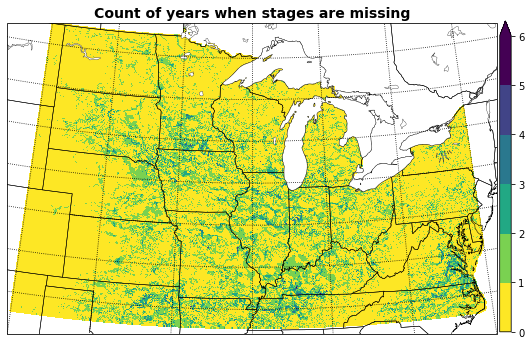

In [3]:
msy = np.load('./var/MissStageYear.npy')

extent = [-105, -75, 34, 49]
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
ax.set_extent(extent)
ax.add_feature(cartopy.feature.BORDERS, lw=.1, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.1, linestyle=':')
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), lw=.5)
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)
ax.gridlines(color="black", linestyle="dotted", lw=.1)

levels = MaxNLocator(nbins=7).tick_values(0, 6)
cmap = plt.get_cmap('viridis_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

pc = plt.pcolormesh(Lon, Lat, np.where(mask, msy, np.nan), cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
plt.title('Count of years when stages are missing', fontweight='bold', fontsize=14)

fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=np.arange(0, 9, 1), extend='max')